# Analiza wstępna

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [93]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print("Test dataset size:", test_data.shape[0])

print("Training dataset size:", train_data.shape[0])
print("Attributes: ", train_data.shape[1])
print("First records of the training dataset:")
display(train_data.head())

print("Data types of the training dataset:")
train_data.info()

Test dataset size: 1459
Training dataset size: 1460
Attributes:  81
First records of the training dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data types of the training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1

# Analiza atrybutów

## Ograniczenie kolumn

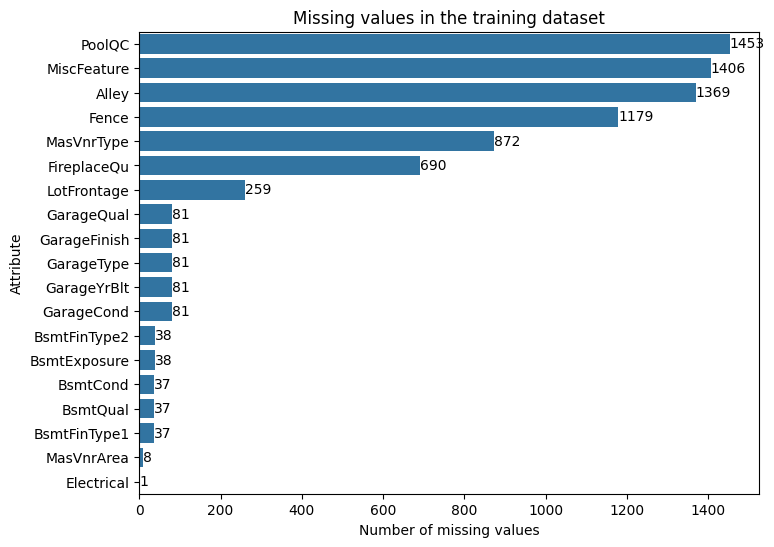


** Columns to delete (big amount of missing values): ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']


In [94]:
# Analiza brakujących wartości
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
# print("Missing values:\n", missing_values)

plt.figure(figsize=(8, 6))
for i in range(missing_values.shape[0]):
    plt.text(missing_values.values[i], i, missing_values.values[i], va='center')
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title('Missing values in the training dataset')
plt.xlabel('Number of missing values')
plt.ylabel('Attribute')
plt.show()

# Usuwanie kolumn z >20% braków
cols_to_drop = missing_values[missing_values > 0.2*len(train_data)].index.tolist()
print("\n** Columns to delete (big amount of missing values):", cols_to_drop)
reduced_train_data = train_data.drop(cols_to_drop, axis=1)

In [95]:
from sklearn.feature_selection import VarianceThreshold

# Analiza wariancji
numerical_cols = reduced_train_data.select_dtypes(include=np.number).columns
variance = reduced_train_data[numerical_cols].var().sort_values()
pd.options.display.float_format = '{:.5f}'.format

print("Variance of numerical columns:")
print(variance)

selector = VarianceThreshold(threshold=0.01)
selector.fit(reduced_train_data[numerical_cols])
low_variance_cols = numerical_cols[~selector.get_support()]

print("\n** Columns to delete (low variance): ", low_variance_cols.tolist())

reduced_train_data = reduced_train_data.drop(low_variance_cols, axis=1)

Variance of numerical columns:
KitchenAbvGr             0.04855
BsmtHalfBath             0.05700
HalfBath                 0.25289
BsmtFullBath             0.26927
FullBath                 0.30351
Fireplaces               0.41559
GarageCars               0.55848
BedroomAbvGr             0.66549
OverallCond              1.23832
YrSold                   1.76384
OverallQual              1.91268
TotRmsAbvGrd             2.64190
MoSold                   7.30959
YearRemodAdd           426.23282
LotFrontage            589.74917
GarageYrBlt            609.58251
3SsnPorch              859.50587
YearBuilt              912.21541
PoolArea              1614.21599
MSSubClass            1789.33831
LowQualFinSF          2364.20405
ScreenPorch           3108.88936
EnclosedPorch         3735.55033
OpenPorchSF           4389.86120
WoodDeckSF           15709.81337
BsmtFinSF2           26023.90778
MasVnrArea           32784.97117
GarageArea           45712.51023
1stFlrSF            149450.07920
Id          

In [96]:
# Analiza korelacji
corr_matrix = reduced_train_data[numerical_cols].corr().abs()

corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = []
high_corr_pairs = []

for col in corr.columns:
    for idx in corr.index:
        corr_val = corr.loc[idx, col]
        if pd.notna(corr_val):
            pairs.append((idx, col, corr_val))
            if corr_val > 0.8:
                high_corr_pairs.append((idx, col, corr_val))

pairs.sort(key=lambda x: x[2], reverse=True)

print("Pairs correlation:")
for col1, col2, corr_val in pairs:
    print(f"{col1} - {col2}: {corr_val:.5f}")
    
print("\n** Columns to delete (high correlation):", [pair[1] for pair in high_corr_pairs])

reduced_train_data = reduced_train_data.drop([pair[1] for pair in high_corr_pairs], axis=1)

Pairs correlation:
GarageCars - GarageArea: 0.88248
YearBuilt - GarageYrBlt: 0.82567
GrLivArea - TotRmsAbvGrd: 0.82549
TotalBsmtSF - 1stFlrSF: 0.81953
OverallQual - SalePrice: 0.79098
GrLivArea - SalePrice: 0.70862
2ndFlrSF - GrLivArea: 0.68750
BedroomAbvGr - TotRmsAbvGrd: 0.67662
BsmtFinSF1 - BsmtFullBath: 0.64921
YearRemodAdd - GarageYrBlt: 0.64228
GarageCars - SalePrice: 0.64041
GrLivArea - FullBath: 0.63001
GarageArea - SalePrice: 0.62343
2ndFlrSF - TotRmsAbvGrd: 0.61642
TotalBsmtSF - SalePrice: 0.61358
2ndFlrSF - HalfBath: 0.60971
1stFlrSF - SalePrice: 0.60585
OverallQual - GarageCars: 0.60067
OverallQual - GrLivArea: 0.59301
YearBuilt - YearRemodAdd: 0.59285
GarageYrBlt - GarageCars: 0.58892
OverallQual - YearBuilt: 0.57232
1stFlrSF - GrLivArea: 0.56602
GarageYrBlt - GarageArea: 0.56457
OverallQual - GarageArea: 0.56202
FullBath - SalePrice: 0.56066
FullBath - TotRmsAbvGrd: 0.55478
OverallQual - YearRemodAdd: 0.55068
OverallQual - FullBath: 0.55060
OverallQual - GarageYrBlt: 0.54

In [97]:
print("Reduced attributes: ", reduced_train_data.shape[1])
print("First records of the reduced training dataset:")
display(reduced_train_data.head())

print("Data types of the reduced training dataset:")
reduced_train_data.info()

Reduced attributes:  71
First records of the reduced training dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00000,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00000,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00000,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00000,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00000,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


Data types of the reduced training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallC

In [98]:
# Uzupełnianie braków dla kolumn numerycznych (mediana)
numerical_cols = reduced_train_data.select_dtypes(include=np.number).columns
reduced_train_data[numerical_cols] = reduced_train_data[numerical_cols].fillna(reduced_train_data[numerical_cols].median())

# Uzupełnianie braków dla kolumn kategorycznych (moda)
categorical_cols = reduced_train_data.select_dtypes(include='object').columns
for col in categorical_cols:
    reduced_train_data[col] = reduced_train_data[col].fillna(reduced_train_data[col].mode()[0])

In [99]:
print("Numeric statistics:")
display(reduced_train_data.describe())

Numeric statistics:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,...,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,730.50000,56.89726,69.86370,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.11712,443.63973,...,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,43.48904,6.32192,2007.81575,180921.19589
std,421.61001,42.30057,22.02768,9981.26493,1.38300,1.11280,30.20290,20.64541,180.73137,456.09809,...,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,496.12302,2.70363,1.32810,79442.50288
min,1.00000,20.00000,21.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000,34900.00000
25%,365.75000,20.00000,60.00000,7553.50000,5.00000,5.00000,1954.00000,1967.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000,129975.00000
50%,730.50000,50.00000,69.00000,9478.50000,6.00000,5.00000,1973.00000,1994.00000,0.00000,383.50000,...,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000,163000.00000
75%,1095.25000,70.00000,79.00000,11601.50000,7.00000,6.00000,2000.00000,2004.00000,164.25000,712.25000,...,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000,214000.00000
max,1460.00000,190.00000,313.00000,215245.00000,10.00000,9.00000,2010.00000,2010.00000,1600.00000,5644.00000,...,857.00000,547.00000,552.00000,508.00000,480.00000,738.00000,15500.00000,12.00000,2010.00000,755000.00000


## Macierz korelacji

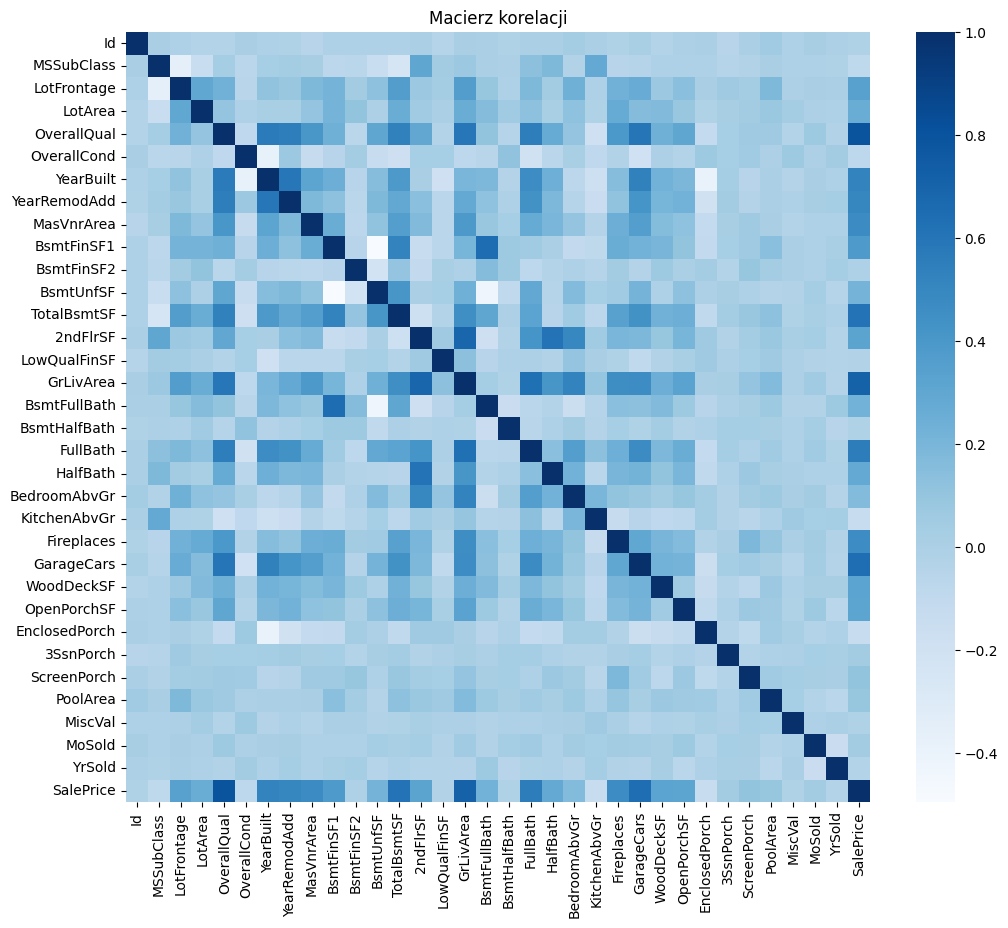

In [110]:
corr_matrix = reduced_train_data[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='Blues')
plt.title('Macierz korelacji')
plt.show()

## Analiza outlierów
przykład dla powierzchni i ceny nieruchomości

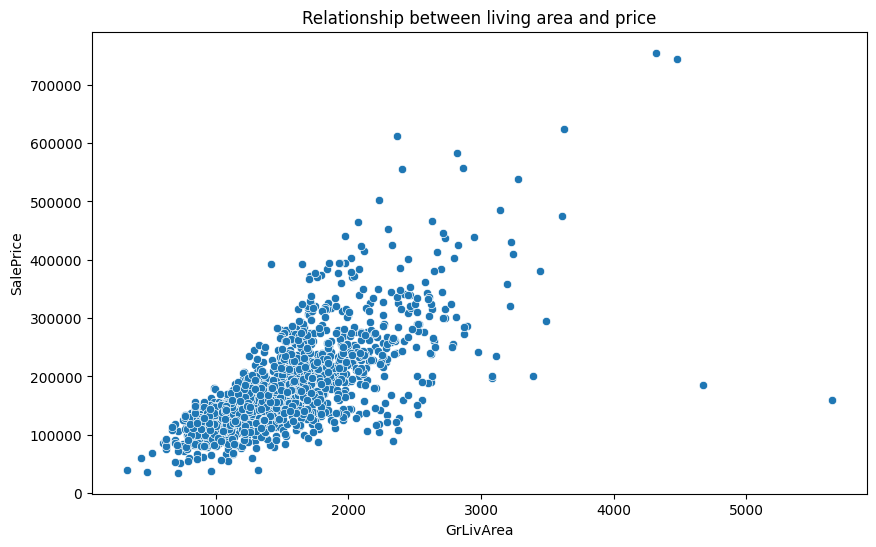

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=reduced_train_data)
plt.title('Relationship between living area and price')
plt.show()

## Rozkład zmiennej docelowej 
przykład dla ceny nieruchomości

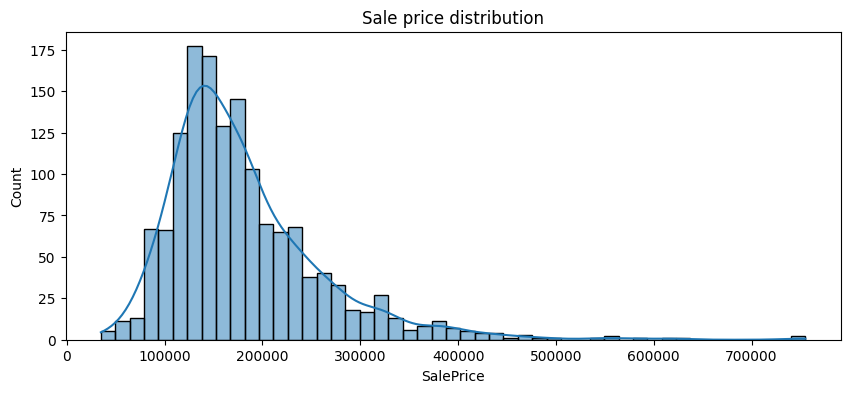

In [113]:
plt.figure(figsize=(10, 4))
sns.histplot(reduced_train_data['SalePrice'], kde=True)
plt.title('Sale price distribution')
plt.show()

In [114]:
top_correlations = corr_matrix['SalePrice'].sort_values(ascending=False)[1:11]
print("Top 10 correlations with SalePrice:")
print(top_correlations)

Top 10 correlations with SalePrice:
OverallQual    0.79098
GrLivArea      0.70862
GarageCars     0.64041
TotalBsmtSF    0.61358
FullBath       0.56066
YearBuilt      0.52290
YearRemodAdd   0.50710
MasVnrArea     0.47261
Fireplaces     0.46693
BsmtFinSF1     0.38642
Name: SalePrice, dtype: float64


# Reguły asocjacyjne - TO DO

# Klasyfikacja

## Feature Importance z Random Forest

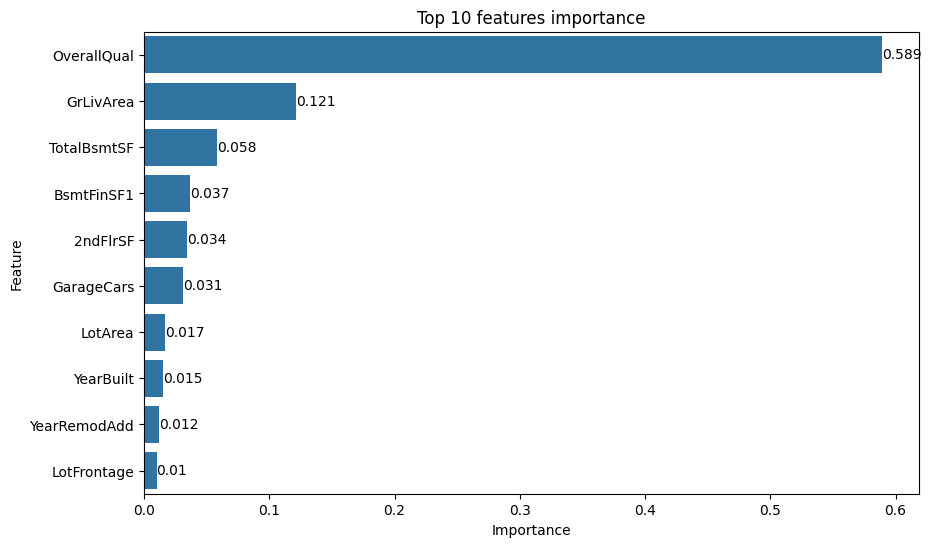

In [121]:
X = reduced_train_data[numerical_cols].drop('SalePrice', axis=1)
y = reduced_train_data['SalePrice']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
for i in range(10):
    plt.text(feature_importance['Importance'].iloc[i], i, round(feature_importance['Importance'].iloc[i], 3), va='center')
plt.title('Top 10 features importance')
plt.show()

# Analiza skupień

# Augmentacja danych